In [5]:
"""numpy to cupy"""
import numpy as np
import cupy as cp


x = np.array([[1,2,3],[4,5,6]])
print(x,'\n', type(x))

cx = cp.asarray(x)
print(cx,'\n', type(cx))

nx = cp.asnumpy(cx)
print(nx,'\n', type(nx))

from cupy import asarray
def np_to_cp(np_data):
    return asarray(np_data)

[[1 2 3]
 [4 5 6]] 
 <class 'numpy.ndarray'>
[[1 2 3]
 [4 5 6]] 
 <class 'cupy.core.core.ndarray'>
[[1 2 3]
 [4 5 6]] 
 <class 'numpy.ndarray'>


In [7]:
import cupy as np
from cupy import asarray, concatenate, zeros, where, unique, asnumpy, bincount, argmax, \
argpartition, argsort, unravel_index, max as cmax, min as cmin, random as crandom
import numpy
import pickle as pkl

def np_to_cp(np_data):
    return asarray(np_data)

with open('./Data/dclus1.pkl', 'rb') as f:
    dclus = pkl.load(f)
    dclus = [np_to_cp(i.astype('float').values) for i in dclus]
    
with open('./Data/pp.pkl', 'rb') as f:
    pp = pkl.load(f)
    pp = [np_to_cp(i.astype('float')) for i in pp]
    
with open('./Data/dd.pkl', 'rb') as f:
    dd = pkl.load(f)
    dd = [np_to_cp(i.astype('float')) for i in dd]
    
def randomSampling(dc, num):
    # lon 최대 최소값, lat 최대 최소값
    max_lon, min_lon = max(dc[:, 0]), min(dc[:, 0])
    max_lat, min_lat = max(dc[:, 1]), min(dc[:, 1])
    
    # lon, lat값 랜덤 생성 후 매칭 반환
    sample_lon = crandom.uniform(low=min_lon, high=max_lon, size=(num,1))
    sample_lat = crandom.uniform(low=min_lat, high=max_lat, size=(num,1))
    return np.concatenate([sample_lon, sample_lat], axis=1)

def trip_Distance(idx, pp):
    """ OD """
    print(pp[idx][:, 4])
    return ((cmax(pp[idx][:, 4])+cmin(pp[idx][:, 4]))-pp[idx][:, 4]).reshape(-1, 1)

def Calculate_distance(X1, X2):
    """ euclidean 거리계산 -> harvasion으로 변경 고려 """
    return ((X1 - X2)**2).sum(1)**0.5

def Calculate_Matrix(idx, dclus, pp, dd):
    """공차 샘플링"""
    # 85% 하차데이터 + 15% 랜덤테이터
    x1 = int(dd[idx].shape[0] * 0.85)
    x2 = dd[idx].shape[0] - x1

    # 15% 랜덤데이터 생성
    rS = randomSampling(dclus[idx], x2)
#     print(rS)

    x3 = crandom.choice(dd[idx].shape[0], x1, replace=False)
#     print(dd[idx][x3][:, :2].shape, rS.shape)
    x3 = np.concatenate([dd[idx][x3][:, :2], rS], axis = 0)

    """ PD """
    x = pp[idx][:, 0:2]     # 승객 위치
    y = x3[:, 0:2]         # 공차 위치
    matrix = np.zeros([x.shape[0],y.shape[0]]) # 매트릭스 초기화


    # d1 계산
    for idx, i in enumerate(x):
        matrix[idx] = Calculate_distance(i, y)
        
    return (cmax(matrix)+cmin(matrix)) - matrix
#     print((cmax(matrix)+cmin(matrix)) - matrix)
    # emin = 0이 아닌 최솟값
#     emin = np.min(np.where(matrix == 0.0, 1, matrix))
#     return 1 / (matrix + emin) * emin

def myHdbscan(train_data_robustScaled, cluster_size = 7):
    """auto HBSCAN"""
    import hdbscan
    test_data = train_data_robustScaled
    clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
    clusterer.fit(test_data)
    return clusterer, unique(clusterer.labels_).shape[0] # label갯수 리턴

def ScaledHdbscan(idx, pp, cluster_size = 7):
    from sklearn.preprocessing import RobustScaler
    
    #outlier 잡기 : Scaling
    robustScaler = RobustScaler()
#     train_data = pp[idx][:, :2]
    train_data = asnumpy(pp[idx][:, :2])
#    print(robustScaler.fit(train_data))
    robustScaler.fit(train_data)
    train_data_robustScaled = robustScaler.transform(train_data)
    
    """ HDBSCAN """
    clusterer, labelNum  = myHdbscan(train_data_robustScaled, cluster_size) # 4 ~ 8
#     print (clusterer, labelNum)
    """ Hdbscan Hyperparameter autoScaling"""
    cnt = 0
    while labelNum > 15:
        cnt += 1
        if cnt > 10:
            break

        # cluster_size 높여서
        cluster_size += 1
        clusterer, labelNum = myHdbscan(train_data_robustScaled, cluster_size)
        
    if labelNum < 3:
        cluster_size += 1
        clusterer, labelNum = myHdbscan(train_data_robustScaled, cluster_size)
        cluster_size -= 1
    
    while labelNum < 3:
        cnt += 1
        if cnt > 4:
#            print("labelNum < 3")
            break
        cluster_size -= 1
        clusterer, labelNum = myHdbscan(train_data_robustScaled, cluster_size)
        
    # Hdbscan 적용
    return clusterer, labelNum

def dbcluster(idx, pp, clusterer, labelNum, k=3):
    """ DS """
    from knn import KNN

    X_train = pp[idx][:, 0:2]
    
    t_train = clusterer.labels_
    # 레이블이 -1부터가 아닌 0부터 시작시키기 위해 + 1
    if -1 in clusterer.labels_:
        t_train = clusterer.labels_ + 1
        
    X_test = pp[idx][:, 2:4]
#    print("label : ", unique(t_train))
    K = 3 # K = 3

    knn_train = KNN(K, X_train, t_train, unique(t_train))
#    knn_train.show_dim()

    y2 = zeros(X_test.shape[0], dtype = int)

    for i in range(X_test.shape[0]):
        knn_train.get_nearest_k(X_test[i])
        y2[i] = knn_train.weighted_majority_vote()
        knn_train.reset()
        
    if -1 not in clusterer.labels_:
        y2 += 1
        
    binc = bincount(y2)
    maxLabel = argmax(binc[1:]) + 1
    maxLabelcount = cmax(binc[1:])
#    print("y2 : ", y2, "\ny2.bincount : ", binc)
#    print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
    # 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 

    y2 = where(y2 == maxLabel, 1.2, where(y2 == 0, 0.8, 1))

    # 수 확인
    values, counts = unique(y2, return_counts=True)
#    print("values: ",values,"counts: ", counts)

    y2 = y2.reshape(-1, 1)
    return y2


episode = 1
PD = Calculate_Matrix(episode, dclus, pp, dd)
OD = trip_Distance(episode, pp)
clusterer, labelNum = ScaledHdbscan(episode, pp, cluster_size = 7)
DS = dbcluster(episode, pp, clusterer, labelNum, k = 3)
matrix = PD * OD * DS
matrix

[1.68 1.3  0.22 ... 3.2  3.3  2.6 ]


array([[ 8.59528447,  8.04618876,  8.9548786 , ...,  8.86662309,
         8.06607953,  4.54309117],
       [11.51506245, 10.40331263, 11.15351352, ..., 10.67639398,
        10.60484893,  6.68679116],
       [14.88868493, 15.30958902, 16.24229726, ..., 15.27720562,
        10.6184303 ,  8.63536496],
       ...,
       [13.29579919, 13.13055508, 14.12136695, ..., 13.25910525,
         9.80093875,  7.59087231],
       [13.72451327, 13.18375574, 13.59743339, ..., 12.71030129,
         9.85096691,  8.01402132],
       [13.14689124, 12.68361204, 14.01857991, ..., 13.63585351,
        10.66113663,  7.1890819 ]])

In [10]:
import numpy as mp
""" newMatrix 조합 후 pick 실험"""
MP = 4000

PP = np.random.normal(MP, MP / 20, PD.shape[0]).reshape(-1, 1)
DP = np.random.normal(MP, MP / 20, PD.shape[1])
MIN = min(matrix.shape[0], matrix.shape[1])
print('MIN: ', MIN)
for i in range(1900, 7800, 100):
# for i in range(1):
# for i in range(3700, 3800, 100):
    next_state = i

    xPP = PP - next_state
    xDP = (next_state - DP)
    
    # 승객입장 Matrix : 거리, 가격을 따짐
    P_Matrix = PD * xPP
    # 운전자입장 Matrix : 거리, OD, DS, 가격을 따짐
    D_Matrix = matrix * xDP

    # 두 Matrix 0 ~ 1 Scaling
    P_Matrix -= P_Matrix.min() # 0 ~
    P_Matrix = P_Matrix / P_Matrix.max() # 0 ~ 1
    D_Matrix -= D_Matrix.min() # 0 ~
    D_Matrix = D_Matrix / D_Matrix.max() # 0 ~ 1

    # 중앙값 : outlier의 영향이 적기 때문,
    Pmid = mp.median(np.asnumpy(P_Matrix))
    Dmid = mp.median(np.asnumpy(D_Matrix))
    
    P_Matrix = np.where(P_Matrix<Pmid, 0, P_Matrix)
    D_Matrix = np.where(D_Matrix<Dmid, 0, D_Matrix)
    newMatrix = P_Matrix * D_Matrix

    newMatrix = np.where(newMatrix == 0., 0, 1)
    
    aa = newMatrix.shape[0]
    bb = newMatrix.shape[1]

    if newMatrix.sum(1).min() == 0:
        aa = np.where(newMatrix.sum(1) == 0, 0, 1).sum()
        
    if newMatrix.sum(0).min() == 0:
        bb = np.where(newMatrix.sum(0) == 0, 0, 1).sum()
        if(bb>newMatrix.shape[0]):
            print(newMatrix.sum(0).shape)
        
    print(i,'가격 = 승객: ', aa,', 운전자: ' , bb, ' , MIN: ', min(aa, bb)," 최종: ", MIN - min(aa, bb))

MIN:  1655
1900 가격 = 승객:  1434 , 운전자:  1588  , MIN:  1434  최종:  221
2000 가격 = 승객:  1421 , 운전자:  1592  , MIN:  1421  최종:  234
2100 가격 = 승객:  1404 , 운전자:  1592  , MIN:  1404  최종:  251
2200 가격 = 승객:  1388 , 운전자:  1594  , MIN:  1388  최종:  267
2300 가격 = 승객:  1367 , 운전자:  1598  , MIN:  1367  최종:  288
2400 가격 = 승객:  1348 , 운전자:  1598  , MIN:  1348  최종:  307
2500 가격 = 승객:  1335 , 운전자:  1599  , MIN:  1335  최종:  320
2600 가격 = 승객:  1318 , 운전자:  1603  , MIN:  1318  최종:  337
2700 가격 = 승객:  1294 , 운전자:  1607  , MIN:  1294  최종:  361
2800 가격 = 승객:  1280 , 운전자:  1610  , MIN:  1280  최종:  375
2900 가격 = 승객:  1251 , 운전자:  1622  , MIN:  1251  최종:  404
3000 가격 = 승객:  1230 , 운전자:  1632  , MIN:  1230  최종:  425
3100 가격 = 승객:  1205 , 운전자:  1642  , MIN:  1205  최종:  450
3200 가격 = 승객:  1169 , 운전자:  1648  , MIN:  1169  최종:  486
(1661,)
3300 가격 = 승객:  1123 , 운전자:  1658  , MIN:  1123  최종:  532
(1661,)
3400 가격 = 승객:  1095 , 운전자:  1660  , MIN:  1095  최종:  560
3500 가격 = 승객:  1052 , 운전자:  1661  , MIN:  1052  최종:  603
3600

In [20]:
import numpy as np
import cupy as cp
import random
aa=[1,2,3,4,5]
print(type(np.random.choice(aa)))
# print(cp.random.choice(aa))
type(np.array([random.choice(aa)])

<class 'numpy.int32'>


int

In [4]:
import pickle as pkl

def data_load():
#     with open('./Data/pclus1.pkl', 'rb') as f:
#         pclus = pkl.load(f)
    with open('./Data/dclus1.pkl', 'rb') as f:
        dclus = pkl.load(f)
    with open('./Data/pp.pkl', 'rb') as f:
        pp = pkl.load(f)
    with open('./Data/dd.pkl', 'rb') as f:
        dd = pkl.load(f)
#     print("dclus: ", dclus, "pp: ", pp, "dd: ", dd)
    return dclus, pp, dd
    
# 완전 랜덤 샘플링
def randomSampling(dc, num):
    # lon 최대 최소값, lat 최대 최소값
    max_lon, min_lon = max(dc['dropoff_longitude']), min(dc['dropoff_longitude'])
    max_lat, min_lat = max(dc['dropoff_latitude']), min(dc['dropoff_latitude'])
    
    # lon, lat값 랜덤 생성 후 매칭 반환             
    sample_lon = np.random.uniform(low=min_lon, high=max_lon, size=(num,1))
    sample_lat = np.random.uniform(low=min_lat, high=max_lat, size=(num,1))
    return np.concatenate([sample_lon, sample_lat], axis=1)

def trip_Distance(idx, pp):
    """ d2 """
    return pp[idx][:, 4].reshape(-1, 1)

def Calculate_distance(X1, X2):
    """ euclidean 거리계산 -> harvasion으로 변경 고려 """
    return ((X1 - X2)**2).sum(1)**0.5

def Calculate_Matrix(idx, dclus, pp, dd):
    """공차 샘플링"""
    # 85% 하차데이터 + 15% 랜덤테이터
    x1 = int(dd[idx].shape[0] * 0.85)
    x2 = dd[idx].shape[0] - x1
    
    # 15% 랜덤데이터 생성
    rS = randomSampling(dclus[idx], x2)

    # 랜덤데이터에 date, time 컬럼 생성
    rSS = np.concatenate([rS, dclus[idx]['date'][0:rS.shape[0]].to_numpy().reshape(-1, 1), \
                    dclus[idx]['time'][0:rS.shape[0]].to_numpy().reshape(-1, 1)], axis= 1)

    # 하차데이터 85% 랜덤 선택, x3 : lat, lon, date, time
    x3 = np.random.choice(dd[idx].shape[0], x1, replace=False)
    x3 = np.concatenate([dd[idx][x3], rSS], axis = 0)

    """ d1 """
    x = pp[idx][:, 0:2]     # 승객 위치
    y = x3[:, 0:2]          # 공차 위치
    matrix = np.zeros([x.shape[0],y.shape[0]]) # 매트릭스 초기화

    # d1 계산
    for idx, i in enumerate(x):
        matrix[idx] = Calculate_distance(i, y)

    # emin = 0이 아닌 최솟값
    emin = np.min(np.where(matrix == 0.0, 1, matrix))
    return 1 / (matrix + emin) * emin
    
def myHdbscan(train_data_robustScaled, cluster_size = 7):
    """auto HBSCAN"""
    import hdbscan
    test_data = train_data_robustScaled
    clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
    clusterer.fit(test_data)
    return clusterer, np.unique(clusterer.labels_).shape[0] # label갯수 리턴

def ScaledHdbscan(idx, pp, cluster_size = 7):
    from sklearn.preprocessing import RobustScaler
    
    #outlier 잡기 : Scaling
    robustScaler = RobustScaler()
    train_data = pp[idx][:, :2]
    print(robustScaler.fit(train_data))
    train_data_robustScaled = robustScaler.transform(train_data)

    # Hdbscan 적용
    return myHdbscan(train_data_robustScaled, cluster_size) # 4 ~ 8

def dbcluster(idx, pp, clusterer, k=3):
    """ y2 """
    from knn import KNN

    X_train = pp[idx][:, 0:2]
    # 레이블이 -1부터가 아닌 0부터 시작시키기 위해 + 1
    t_train = clusterer.labels_ + 1
    X_test = pp[idx][:, 2:4]
    print("label : ", np.unique(t_train))
    K=3 # K = 3

    knn_train = KNN(K, X_train, t_train, np.unique(t_train))
    knn_train.show_dim()

    y2 = np.zeros(X_test.shape[0], dtype = int)

    for i in range(X_test.shape[0]):
        knn_train.get_nearest_k(X_test[i])
        y2[i] = knn_train.weighted_majority_vote()
        knn_train.reset()

    binc = np.bincount(y2)
    maxLabel = np.argmax(binc)
    maxLabelcount = np.max(binc)
    print("y2 : ", y2, "\ny2.bincount : ", binc)
    print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
    # 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 
    y2 = np.where(y2 == maxLabel, 1.2, (np.where(y2 == 0, 0.8, 1)))

    # 수 확인
    values, counts = np.unique(y2, return_counts=True)
    print("values: ",values,"counts: ", counts)

    y2 = y2.reshape(-1, 1)
    return y2

In [33]:

"""
방법 1
PD, OD, DS, PP, DP, MP 모두 통합된 Matrix  
"""
marketPrice= 3800
marketPrice1= 4000
episode=0
dclus, pp, dd = data_load()

PD = Calculate_Matrix(episode, dclus, pp, dd)
OD = trip_Distance(episode, pp)
clusterer, labelNum = ScaledHdbscan(episode, pp, cluster_size = 7)
DS = dbcluster(episode, pp, clusterer, k = 3)

# 1 episode 마다 정해진 승객과 운전자의 선호가격
p_array = np.random.normal(marketPrice, marketPrice / 20, PD.shape[0]) 
d_array = np.random.normal(marketPrice, marketPrice / 20, PD.shape[1]).reshape(-1, 1)


matrix = PD * OD * DS
print(matrix)
print(PD.shape[0], PD.shape[1])

ValueError: object __array__ method not producing an array

In [37]:

"""
방법 2
승객 Matrix A = PD, PP, MP
운전자 Matrix B = PD, OD, DS, DP, MP
New Matrix = A + B - ( l A - B l / 2 ) = (A + 3B) / 2
"""
MP = 3800 
next_state = 3900 # next_state의 시장가격이 3900이라면
PP = np.random.normal(MP, MP / 20, PD.shape[0]).reshape(-1, 1)
DP = np.random.normal(MP, MP / 20, PD.shape[1])
# PP array 생성 -1.0 ~ 1.0
xPP = PP - next_state
maxAbsPP = np.array([np.abs(xPP.max()), np.abs(xPP.min())]).max()
xPP = xPP / maxAbsPP

# DD array 생성 -1.0 ~ 1.0
xDP = next_state - DP
maxAbsDP = np.array([np.abs(xDP.max()), np.abs(xDP.min())]).max()
xDP = xDP / maxAbsDP

print(xPP.max(), xPP.min(), xDP.max(),xDP.min())
print("PD: ", PD)
print("OD: ", OD)
print("DS: " , DS)
print("xPP: ", xPP)
print("xDP: " , xDP)
P_Matrix = PD * xPP
D_Matrix = PD * OD * DS * xDP
if P_Matrix.min() < 0:
    P_Matrix -= P_Matrix.min()
if D_Matrix.min() < 0:
    D_Matrix -= D_Matrix.min()
    
print(P_Matrix.max(), P_Matrix.min(), D_Matrix.max(), D_Matrix.min())
newMatrix = (P_Matrix + D_Matrix) - (np.abs(P_Matrix-D_Matrix) / 2)
print(newMatrix.max(), newMatrix.min())
print("P_Matrix: ", P_Matrix)
print("D_Matrix: ", D_Matrix)
print("newMatrix: " , newMatrix)


0.5001869198557976 -1.0 1.0 -0.7769355697039314
PD:  [[1.56688317e-04 2.26256253e-04 3.95954559e-04 ... 6.73991550e-05
  1.30581121e-04 1.26186209e-04]
 [3.10016219e-04 1.17802829e-03 2.00324042e-04 ... 5.78832199e-05
  1.78585926e-04 9.28685258e-05]
 [1.90316189e-04 2.32026564e-04 6.35290012e-04 ... 7.23584379e-05
  1.14677397e-04 1.37238884e-04]
 ...
 [1.40347317e-04 1.94358616e-04 3.90082706e-04 ... 6.88208069e-05
  1.23339718e-04 1.32468152e-04]
 [1.91286128e-04 4.27699535e-04 1.64770682e-04 ... 5.38797192e-05
  2.58243578e-04 8.51561374e-05]
 [1.99593743e-04 3.23521921e-04 3.30805366e-04 ... 6.44716251e-05
  1.44179384e-04 1.13991298e-04]]
OD:  [[4.68]
 [4.23]
 [3.31]
 ...
 [3.12]
 [6.96]
 [0.12]]
DS:  [[1.2]
 [1.2]
 [1.2]
 ...
 [1.2]
 [1.2]
 [1.2]]
xPP:  [[-0.29287446]
 [-0.19912134]
 [-0.16984594]
 ...
 [ 0.20682642]
 [-0.0411997 ]
 [ 0.11952695]]
xDP:  [-0.34093362 -0.23651891 -0.10839508 ... -0.0332949   0.15810525
  0.05383921]
0.2643857860188773 0.0 1.5026186591034574 0.0
1.

In [38]:
print(PD.shape, xPP.shape)
# aa = np.array([[1,2],
#               [2,3],
#               [3,4]])
# bb = np.array([[1],[2],[3]])
# print(aa.shape, bb.shape)
# print(aa*bb)
sa = PD * xPP
sb = PD * OD * DS * xDP
print(sa.max(), sa.min())
sa = np.where(sa == sa.max(), 0, sa)
sa = np.where(sa == sa.min(), 0, sa)
print(sa.max(), sa.min(),'\n===========================')

print(sb.max(), sb.min())
sb = np.where(sb == sb.max(), 0, sb)
sb = np.where(sb == sb.min(), 0, sb)
print(sb.max(), sb.min())

(1520, 1154) (1520, 1)
0.13338930704837332 -0.130996478970504
0.043424474409366205 -0.10077356883912772 
0.8235650404519173 -0.6790536186515401
0.8013524842300042 -0.18175501604830183


1754080


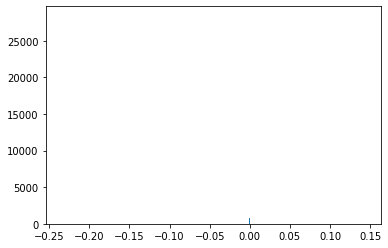

In [26]:
import numpy as np
import matplotlib.pyplot as plt

a = sa.flatten()
print(len(a))
# a = np.array([1,3,5,7,8])
# np.sum(a>4)
n, bins, patches = plt.hist(a, bins = 175408)
plt.show()

In [8]:
"""가격 차이 Matrix"""

marketPrice= 3800
d = np.array([4,5,6])
p = np.array([[10],[100],[1000]])
print(p-d)
p_array = np.random.normal(marketPrice, marketPrice / 20, ary.shape[0]) 
d_array = np.random.normal(marketPrice, marketPrice / 20, ary.shape[1]).reshape(-1, 1)
print("p_array: ",p_array, "\nd_array: ", d_array)
matrix2 = d_array - p_array
print("matrix2: ", matrix2)
print("matrix2.mean(): ", matrix2.mean())
print("matrix2.std(): ", matrix2.std())
print("matrix2.max(): ", matrix2.max(), "\nmatrix2.min(): ", matrix2.min())

[[  6   5   4]
 [ 96  95  94]
 [996 995 994]]
p_array:  [3519.59908827 3502.78437821 3835.76217562 ... 3833.95737378 3375.62975492
 4039.95914493] 
d_array:  [[3827.01085973]
 [3924.30928334]
 [3878.13410899]
 ...
 [3796.679367  ]
 [3790.51715225]
 [4023.3749825 ]]
matrix2:  [[ 307.41177146  324.22648153   -8.75131588 ...   -6.94651405
   451.38110482 -212.94828519]
 [ 404.71019507  421.52490513   88.54710772 ...   90.35190955
   548.67952842 -115.64986159]
 [ 358.53502072  375.34973078   42.37193337 ...   44.17673521
   502.50435407 -161.82503594]
 ...
 [ 277.08027874  293.8949888   -39.08280861 ...  -37.27800678
   421.04961209 -243.27977792]
 [ 270.91806398  287.73277405  -45.24502336 ...  -43.44022153
   414.88739734 -249.44199267]
 [ 503.77589423  520.5906043   187.61280689 ...  189.41760872
   647.74522759  -16.58416242]]
matrix2.mean():  15.056943781687966
matrix2.std():  273.3981858547083
matrix2.max():  1192.9809026192297 
matrix2.min():  -1190.215049923684


In [9]:
"""Matrix 순위대로 뽑기"""
import time
import numpy as np

t = time.time()
episode=0
# dclus, pp, dd = data_load()
# print(dclus[0], pp[0], dd[0])

# d1Matrix = Calculate_Matrix(episode, dclus, pp, dd)
# d2 = trip_Distance(episode, pp)
# clusterer, labelNum = ScaledHdbscan(episode, pp, cluster_size = 7)
# y2 = dbcluster(episode, pp, clusterer, k = 3)
# matrix = d1Matrix * d2 * y2
# ary = np.array([[0.12,0.21,0.1,0.15],
#               [0.2,0.3,0.24,0.33],
#              [0.34,0.11,0.51,0.91],
#                [0.30,0.20,0.10,0.99]])
ary = d1Matrix
n = ary.size
flat = ary.flatten()
indices = np.argpartition(flat, -n)[-n:]
indices = indices[np.argsort(-flat[indices])]
x = np.unravel_index(indices, ary.shape)
print(x, ary.shape[0], ary.shape[1], n)

x1 = np.zeros(ary.shape[0], dtype=int)
y1 = np.zeros(ary.shape[0], dtype=int)
x2 = np.zeros(ary.shape[1], dtype=int)
y2 = np.zeros(ary.shape[1], dtype=int)
xx = x[0]
yy = x[1]
idx=0
for i in range(n):
    if(not x1[xx[i]] and not y1[yy[i]]):
#         print(i, ": ",xx[i], yy[i])
        x1[xx[i]] = 1
        y1[yy[i]] = 1
        x2[idx]=xx[i]
        y2[idx]=yy[i]
        idx+=1
print("x1 : ", x1,"\ny1: ", y1)
print("x1.shape[0] : ", x1.shape[0], "\ny1.shape[0] : ", y1.shape[0],"\nidx: ", idx)
print("x2: ", x2, "\ny2 : ", y2, "\nx2.shape[0]: ", x2.shape[0], "\ny2.shape[0]: ", y2.shape[0])
print("matrix: ", np.max(matrix))
print(time.time()-t)

(array([ 123,   18,  848, ...,  404, 1139, 1079], dtype=int64), array([ 202,  644,  110, ..., 1137,  939,  939], dtype=int64)) 1520 1154 1754080
x1 :  [0 1 1 ... 1 1 1] 
y1:  [1 1 1 ... 0 0 0]
x1.shape[0] :  1520 
y1.shape[0] :  1520 
idx:  1154
x2:  [ 123   18  848 ... 1096 1446 1158] 
y2 :  [ 202  644  110 ... 1090 1131 1049] 
x2.shape[0]:  1154 
y2.shape[0]:  1154
matrix:  6.04
1.3423020839691162


In [5]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import time
t = time.time()

# pickup = pd.read_pickle("./Data/pickup.pkl")
# dropoff = pd.read_pickle("./Data/dropoff.pkl")

pclus = pd.read_pickle("./Data/pclus.pkl")
dclus = pd.read_pickle("./Data/dclus.pkl")

# Sampling
pp, dd = [], []
for i in range(len(pclus)):
    pclus[i] = pclus[i].sample(frac=0.05, random_state=0)
    dclus[i] = dclus[i].sample(frac=0.05, random_state=0)
    pp.append(pclus[i].to_numpy())
    dd.append(dclus[i].to_numpy())

print("load_time : ", time.time() - t)

with open('./Data/pclus1.pkl', 'wb')as f:
    pkl.dump(pclus, f)
with open('./Data/dclus1.pkl', 'wb')as f:
    pkl.dump(dclus, f)
with open('./Data/pp.pkl', 'wb')as f:
    pkl.dump(pp, f)
with open('./Data/dd.pkl', 'wb')as f:
    pkl.dump(dd, f)

load_time :  11.535686492919922


In [2]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

with open('./Data/pclus1.pkl', 'rb') as f:
    pclus = pkl.load(f)
with open('./Data/dclus1.pkl', 'rb') as f:
    dclus = pkl.load(f)
with open('./Data/pp.pkl', 'rb') as f:
    pp = pkl.load(f)
with open('./Data/dd.pkl', 'rb') as f:
    dd = pkl.load(f)
    
episode = 9

""" d2 """
d2 = pp[episode][:, 4].reshape(-1, 1)

"""공차 샘플링"""
x1 = int(dd[episode].shape[0] * 0.85)
x2 = dd[episode].shape[0] - x1

# 완전 랜덤 샘플링
def randomSampling(dc, size = 100):
    max_lon, min_lon = max(dc['dropoff_longitude']), min(dc['dropoff_longitude'])
    max_lat, min_lat = max(dc['dropoff_latitude']), min(dc['dropoff_latitude'])
    sample_lon = np.random.uniform(low=min_lon, high=max_lon, size=(size,1))
    sample_lat = np.random.uniform(low=min_lat, high=max_lat, size=(size,1))
    return np.concatenate([sample_lon, sample_lat], axis=1)
    
rS = randomSampling(dclus[episode], x2)

rSS = np.concatenate([rS, dclus[episode]['date'][0:rS.shape[0]].to_numpy().reshape(-1, 1), \
                dclus[episode]['time'][0:rS.shape[0]].to_numpy().reshape(-1, 1)], axis= 1)

# 공차 Sampling
x3 = np.random.choice(dd[episode].shape[0], x1, replace=False)
x3 = np.concatenate([dd[episode][x3], rSS], axis = 0)
x4 = x3[:, 0:2]
print(x3, x4, x4.shape)
plt.scatter(*x4.T, s=10, linewidth=0, alpha=0.6)



[[-73.922235 40.743422 '01' '09']
 [-73.991895 40.749502 '01' '09']
 [-73.78237799999998 40.648792 '01' '09']
 ...
 [-74.0448537727064 40.694200928928865 '01' '09']
 [-73.9606658042421 40.64753412955718 '01' '09']
 [-73.91553088085345 40.7422175808465 '01' '09']] [[-73.922235 40.743422]
 [-73.991895 40.749502]
 [-73.78237799999998 40.648792]
 [-73.984657 40.736823]
 [-73.953953 40.777108]
 [-73.982247 40.76948]
 [-73.99176 40.73772]
 [-73.983362 40.75053]
 [-73.984584 40.76756]
 [-74.00598599999998 40.726452]
 [-73.975724 40.752055]
 [-73.991392 40.750357]
 [-73.9127 40.744102]
 [-73.982335 40.777317]
 [-73.98653 40.730968]
 [-73.98067299999998 40.761842]
 [-73.948267 40.82446]
 [-73.790186 40.643555]
 [-73.884693 40.744465]
 [-73.99810499999998 40.745193]
 [-73.967746 40.709891]
 [-73.96655599999998 40.77045]
 [-73.873068 40.7744]
 [-73.991012 40.756805]
 [-73.994226 40.741178]
 [-73.980925 40.756847]
 [-73.985107 40.767915]
 [-73.990628 40.757568]
 [-73.950748 40.6698]
 [-73.97437399

NameError: name 'data_load' is not defined

In [19]:
"""승객 위치 hdbscan"""
import hdbscan
from sklearn.preprocessing import RobustScaler

def myHdbscan(train_data_robustScaled, cluster_size):
    """auto HBSCAN"""
    test_data = train_data_robustScaled
    clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
    clusterer.fit(test_data)
    return clusterer, np.unique(clusterer.labels_).shape[0] # label갯수 리턴

def ScaledHdbscan(idx, pp, cluster_size = 7):
    from sklearn.preprocessing import RobustScaler
    # parameter
    idx = 2
    cluster_size = 10

    #outlier 잡기 : Scaling
    robustScaler = RobustScaler()
    train_data = pp[idx][:, :2]
    print(robustScaler.fit(train_data))
    train_data_robustScaled = robustScaler.transform(train_data)

    # Hdbscan 적용
    return clusterer, labelNum  = myHdbscan(train_data_robustScaled, cluster_size) # 4 ~ 8

""" dbscan autoScaling"""
while labelNum < 3 or labelNum > 8:
        # cluster_size 높여가며
        if cluster_size1 < 20:
            cluster_size1 += 1
            clusterer1, labelNum1 = autoHdbscan(train_data_robustScaled, cluster_size1)
            
        # cluster_size 줄여가며
        if cluster_size2 > 2:
            cluster_size2 -= 1
            clusterer2, labelNum2 = autoHdbscan(train_data_robustScaled, cluster_size2)
            
        if labelNum1 >= 3 and labelNum1 <= 8:
            clusterer, labelNum, c luster_size = clusterer1, labelNum1, cluster_size1
            break
            
        if labelNum2 >= 3 and labelNum2 <= 8:
            clusterer, labelNum, cluster_size = clusterer2, labelNum2, cluster_size2
            break
        
        if cluster_size1 >= 20 and cluster_size2 <= 2:
            print("Can't run autoHdbscan\n")
            break

# label 수
print(idx, labelNum, cluster_size, clusterer.labels_.shape)

for i in np.unique(clusterer.labels_):
    print(i, "Label count : " ,clusterer.labels_[clusterer.labels_ == i].size)
    
""" y2 """
from knn import KNN

X_train = pp[idx][:, 0:2]
# 레이블이 -1부터가 아닌 0부터 시작시키기 위해 + 1
t_train = clusterer.labels_ + 1
X_test = pp[idx][:, 2:4]
print("label : ", np.unique(t_train))
K=3 # K = 3

knn_train = KNN(K, X_train, t_train, np.unique(t_train))
knn_train.show_dim()

y2 = np.zeros(X_test.shape[0], dtype = int)

for i in range(X_test.shape[0]):
    knn_train.get_nearest_k(X_test[i])
    y2[i] = knn_train.weighted_majority_vote()
    knn_train.reset()
    

binc = np.bincount(y2)
maxLabel = np.argmax(binc)
maxLabelcount = np.max(binc)
print("y2 : ", y2, "\ny2.bincount : ", binc)
print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
# 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 
y2 = np.where(y2 == maxLabel, 1.2, (np.where(y2 == 0, 0.8, 1)))

# 수 확인
values, counts = np.unique(y2, return_counts=True)
print("values: ",values,"counts: ", counts)

y2 = y2.reshape(-1, 1)
y2, y2.shape

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
2 8 10 (1510,)
-1 Label count :  123
0 Label count :  36
1 Label count :  10
2 Label count :  77
3 Label count :  16
4 Label count :  31
5 Label count :  32
6 Label count :  1185
label :  [0 1 2 3 4 5 6 7]
Input Dimension:  (1510, 2)
Output Dimension:  (1510,)
y2 :  [7 0 0 ... 7 7 0] 
y2.bincount :  [ 246   72   11   49   17   31   45 1039]
maxLabel:  7 maxLabelcount :  1039
values:  [0.8 1.  1.2] counts:  [ 246  225 1039]


(array([[1.2],
        [0.8],
        [0.8],
        ...,
        [1.2],
        [1.2],
        [0.8]]), (1510, 1))

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
-1 Label count :  21
0 Label count :  13
1 Label count :  295
2 Label count :  9
(338, 7) (338, 1)


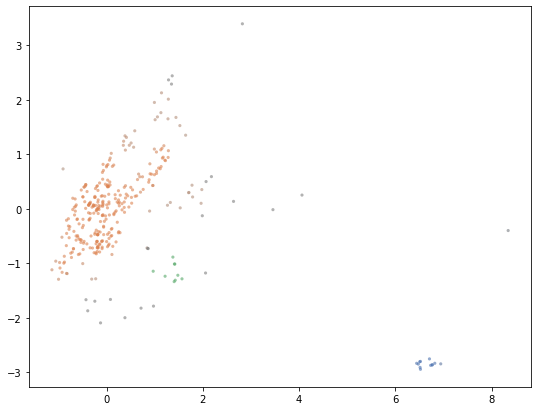

In [97]:
"""승객 위치 hdbscan"""
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
plt.rcParams["figure.figsize"] = [9,7]

episode = 7
cluster_size=9

#outlier 잡기
robustScaler = RobustScaler()
train_data = pp[episode][:, :2]
print(robustScaler.fit(train_data))
train_data_robustScaled = robustScaler.transform(train_data)
# print(train_data_robustScaled)
#HBSCAN
test_data = train_data_robustScaled
clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
clusterer.fit(test_data)
# clusterer.labels_ += 1 # Label 0부터 시작하도록
# print("Max label : ", clusterer.labels_.max())
# print(np.unique(clusterer.labels_))
for i in np.unique(clusterer.labels_):
    print(i, "Label count : " ,clusterer.labels_[clusterer.labels_ == i].size)

color_palette = sns.color_palette('deep', 12)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*test_data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.6)

cc = clusterer.labels_.reshape(-1, 1)
print(pp[idx].shape, cc.shape)
pp1 = np.concatenate((pp[idx][:,0:5], cc), axis = 1)  # pickup (lat,lon), dropoff(lat,lon), d2 , y2
pp1 = np.concatenate((pp1, pp[idx][:,5:7]), axis = 1) # day, time
pp1

with open('./Data/P0100.pkl', 'wb')as f:
    pkl.dump(pp1, f) # pickup (lat,lon), dropoff(lat,lon), d2 , y2, day, time -> 7가지

In [14]:
""" y2 """
from knn import KNN

X_train = pp[episode][:, 0:2]
# 레이블이 -1부터가 아닌 0부터 시작시키기 위해 + 1
t_train = clusterer.labels_ + 1
X_test = pp[episode][:, 2:4]
print("label : ", np.unique(t_train))
K=3 # K = 3

knn_iris = KNN(K, X_train, t_train, np.unique(t_train))
knn_iris.show_dim()

y2 = np.zeros(X_test.shape[0], dtype = int)

for i in range(X_test.shape[0]):
    knn_iris.get_nearest_k(X_test[i])
    y2[i] = knn_iris.weighted_majority_vote()
    knn_iris.reset()
    

binc = np.bincount(y2)
maxLabel = np.argmax(binc)
maxLabelcount = np.max(binc)
print("y2 : ", y2, "\ny2.bincount : ", binc)
print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
# 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 
y2 = np.where(y2 == maxLabel, 1.2, (np.where(y2 == 0, 0.8, 1)))

# 수 확인
values, counts = np.unique(y2, return_counts=True)
print("values: ",values,"counts: ", counts)

y2 = y2.reshape(-1, 1)

2
label :  [0 1 2 3 4 5 6 7]
Input Dimension:  (1510, 2)
Output Dimension:  (1510,)
y2 :  [7 0 0 ... 7 7 0] 
y2.bincount :  [ 246   72   11   49   17   31   45 1039]
maxLabel:  7 maxLabelcount :  1039
values:  [0.8 1.  1.2] counts:  [ 246  225 1039]


In [23]:
""" d1 """
idx = 2
x1 = pp[idx][:, 0:2] # 승객 위치
y1 = x4              # 공차 위치


def Calculate_distance(X1, X2):
    """ euclidean 거리계산 -> harvasion으로 변경 고려 """
    return ((X1 - X2)**2).sum(1)**0.5

mat = np.zeros([x1.shape[0],y1.shape[0]]) #초기화

# d2 계산
for idx, i in enumerate(x1):
    mat[idx] = Calculate_distance(i, y1)

emin = np.min(np.where(mat==0.0, 1, mat))
d1 = 1 / (mat + emin) * emin
d1, d1.shape

NameError: name 'x4' is not defined

In [20]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
import math

a1 = np.array([[1,2,3,4],
              [5,6,7,8]])
b1 = np.array([[1],[2]])
xx = d1 * d2 * y2

yyy = xx.size
xxx = xx.reshape(-1,)
print(yyy, np.min(xxx))
# ax = np.random.choice(100, 100)
plt.figure(figsize = [10,10])
xx.unique()
# plt.hist(xxx, bins=yyy)

NameError: name 'd1' is not defined

C:\Users\Jun\anaconda3\lib\site-packages\ipykernel_launcher.py:307: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
label :  [0 1 2 3 4 5]
Input Dimension:  (1520, 2)
Output Dimension:  (1520,)
y2 :  [5 5 5 ... 5 5 5] 
y2.bincount :  [ 178    5   16   25   27 1269]
maxLabel:  5 maxLabelcount :  1269
values:  [0.8 1.  1.2] counts:  [ 178   73 1269]
1
episode: 0   score: 3720  global_step: 1   epsilon: 0.9999
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
3360 [0.0, 0.0, 0.0, 0.0, 0.0]
89
90
91
92
93
94
95
96
97
98
99
100
101
episode: 0   score: 3420  global_step: 101   epsilon: 0.989950333757503
102
103
104
105
106
107
108


KeyboardInterrupt: 

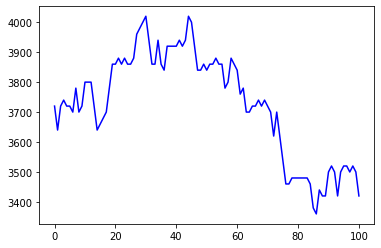

In [6]:
# Q-learning table사용
import scipy
import scipy.stats
import numpy as np
import random
import pylab
from collections import defaultdict
import pickle as pkl
from tqdm import tqdm_notebook

INITIALPRICE = 3800

def data_load():
#     with open('./Data/pclus1.pkl', 'rb') as f:
#         pclus = pkl.load(f)
    with open('./Data/dclus1.pkl', 'rb') as f:
        dclus = pkl.load(f)
    with open('./Data/pp.pkl', 'rb') as f:
        pp = pkl.load(f)
    with open('./Data/dd.pkl', 'rb') as f:
        dd = pkl.load(f)
    return dclus, pp, dd
    
# 완전 랜덤 샘플링
def randomSampling(dc, num):
    # lon 최대 최소값, lat 최대 최소값
    max_lon, min_lon = max(dc['dropoff_longitude']), min(dc['dropoff_longitude'])
    max_lat, min_lat = max(dc['dropoff_latitude']), min(dc['dropoff_latitude'])
    
    # lon, lat값 랜덤 생성 후 매칭 반환
    sample_lon = np.random.uniform(low=min_lon, high=max_lon, size=(num,1))
    sample_lat = np.random.uniform(low=min_lat, high=max_lat, size=(num,1))
    return np.concatenate([sample_lon, sample_lat], axis=1)

def trip_Distance(idx, pp):
    """ OD """
    return pp[idx][:, 4].reshape(-1, 1)

def Calculate_distance(X1, X2):
    """ euclidean 거리계산 -> harvasion으로 변경 고려 """
    return ((X1 - X2)**2).sum(1)**0.5

def Calculate_Matrix(idx, dclus, pp, dd):
    """공차 샘플링"""
    # 85% 하차데이터 + 15% 랜덤테이터
    x1 = int(dd[idx].shape[0] * 0.85)
    x2 = dd[idx].shape[0] - x1
    
    # 15% 랜덤데이터 생성
    rS = randomSampling(dclus[idx], x2)

    # 랜덤데이터에 date, time 컬럼 생성
    rSS = np.concatenate([rS, dclus[idx]['date'][0:rS.shape[0]].to_numpy().reshape(-1, 1), \
                    dclus[idx]['time'][0:rS.shape[0]].to_numpy().reshape(-1, 1)], axis= 1)

    # 하차데이터 85% 랜덤 선택, x3 : lat, lon, date, time
    x3 = np.random.choice(dd[idx].shape[0], x1, replace=False)
    x3 = np.concatenate([dd[idx][x3], rSS], axis = 0)

    """ PD """
    x = pp[idx][:, 0:2]     # 승객 위치
    y = x3[:, 0:2]          # 공차 위치
    matrix = np.zeros([x.shape[0],y.shape[0]]) # 매트릭스 초기화

    # d1 계산
    for idx, i in enumerate(x):
        matrix[idx] = Calculate_distance(i, y)

    # emin = 0이 아닌 최솟값
    emin = np.min(np.where(matrix == 0.0, 1, matrix))
    return 1 / (matrix + emin) * emin
    
def myHdbscan(train_data_robustScaled, cluster_size = 7):
    """auto HBSCAN"""
    import hdbscan
    test_data = train_data_robustScaled
    clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
    clusterer.fit(test_data)
    return clusterer, np.unique(clusterer.labels_).shape[0] # label갯수 리턴

def ScaledHdbscan(idx, pp, cluster_size = 7):
    from sklearn.preprocessing import RobustScaler
    
    #outlier 잡기 : Scaling
    robustScaler = RobustScaler()
    train_data = pp[idx][:, :2]
    print(robustScaler.fit(train_data))
    train_data_robustScaled = robustScaler.transform(train_data)

    # Hdbscan 적용
    return myHdbscan(train_data_robustScaled, cluster_size) # 4 ~ 8

def dbcluster(idx, pp, clusterer, k=3):
    """ DS """
    from knn import KNN

    X_train = pp[idx][:, 0:2]
    # 레이블이 -1부터가 아닌 0부터 시작시키기 위해 + 1
    t_train = clusterer.labels_ + 1
    X_test = pp[idx][:, 2:4]
    print("label : ", np.unique(t_train))
    K=3 # K = 3

    knn_train = KNN(K, X_train, t_train, np.unique(t_train))
    knn_train.show_dim()

    y2 = np.zeros(X_test.shape[0], dtype = int)

    for i in range(X_test.shape[0]):
        knn_train.get_nearest_k(X_test[i])
        y2[i] = knn_train.weighted_majority_vote()
        knn_train.reset()

    binc = np.bincount(y2)
    maxLabel = np.argmax(binc)
    maxLabelcount = np.max(binc)
    print("y2 : ", y2, "\ny2.bincount : ", binc)
    print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
    # 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 
    y2 = np.where(y2 == maxLabel, 1.2, (np.where(y2 == 0, 0.8, 1)))

    # 수 확인
    values, counts = np.unique(y2, return_counts=True)
    print("values: ",values,"counts: ", counts)

    y2 = y2.reshape(-1, 1)
    return y2
def mat2(PP, DP, next_state, PD, matrix):
    # PP array 생성 -1.0 ~ 1.0
    xPP = PP - next_state
    maxAbsPP = np.array([np.abs(xPP.max()), np.abs(xPP.min())]).max()
    xPP = xPP / maxAbsPP

    # DD array 생성 -1.0 ~ 1.0
    xDP = next_state - DP
    maxAbsDP = np.array([np.abs(xDP.max()), np.abs(xDP.min())]).max()
    xDP = xDP / maxAbsDP

    P_Matrix = PD * xPP
    D_Matrix = matrix * xDP
    if P_Matrix.min() < 0:
        P_Matrix -= P_Matrix.min()
    if D_Matrix.min() < 0:
        D_Matrix -= D_Matrix.min()

    return (P_Matrix + D_Matrix) - (np.abs(P_Matrix-D_Matrix) / 2)

def pick(mat, threshold = 0.4):
    n = mat.size
    flat = mat.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    x = np.unravel_index(indices, mat.shape)
#     print(x, mat.shape[0], mat.shape[1], n)
    xx = x[0]
    yy = x[1]
    
    x1 = np.zeros(mat.shape[0], dtype=int)
    y1 = np.zeros(mat.shape[0], dtype=int)
    x2 = np.zeros(mat.shape[1], dtype=int)
    y2 = np.zeros(mat.shape[1], dtype=int)

    idx=0
    for i in range(n):
        if(not x1[xx[i]] and not y1[yy[i]]):
    #         print(i, ": ",xx[i], yy[i])
    #   기준 점 잡기
            x1[xx[i]] = 1
            y1[yy[i]] = 1
            x2[idx]=xx[i]
            y2[idx]=yy[i]
            idx+=1
            
    return idx

# 환경
class Env:
    def __init__(self):
        self.action_space = ['u', 'l', 'c', 'r', 'd'] # 행동 순서대로 -80, -20, 0, +20, +80
        self.n_actions = len(self.action_space)  # 5 actions
        self.marketPrice = INITIALPRICE          # marketPrice 
        self.initPrice = INITIALPRICE            # InitialPrice
        self.PP = None    #Passenger의 선호 가격 리스트
        self.passengers = None #승객의 수 초기 500명
        self.DP = None    #Driver의 선호 가격 리스트
        self.drivers = None    #운전자 수 초기 500명
        self.matrix = None # matching matrix
        self.PD = None
    
    def step(self, action):
        if   action == 0:   # up : price-=80
            self.marketPrice-=80
            
        elif action == 1:   # left : price-=20
            self.marketPrice-=20
            
        elif action == 2:   # center : Nothing happen
            pass
        
        elif action == 3:   # right : price+=20
            self.marketPrice+=20

        elif action == 4:   # down : price+=80
            self.marketPrice+=80


        next_state = self.marketPrice
        reward = 0
        match = 0
        threshold = 0.4   # 기준점 어떻게?
        
        #보상 가격허용치를 넘으면 -100
        if next_state < (self.initPrice / 2) or next_state > (self.initPrice * 2):
            reward = -100
            
        else:
            """ 방법 2 Matrix 생성 후 뽑기"""
            newMatrix = mat2(self.PP, self.DP, next_state, self.PD, self.matrix)
            match = pick(newMatrix, threshold)
            reward = match * (next_state/1000)

        return next_state, reward
        
    def reset(self, PD, matrix):
        self.passengers = matrix.shape[0]
        self.drivers = matrix.shape[1]
        self.PP = np.random.normal(self.marketPrice, self.marketPrice / 20, self.passengers).reshape(-1, 1) #Passenger의 선호 가격 리스트
        self.DP = np.random.normal(self.marketPrice, self.marketPrice / 20, self.drivers) #Driver의 선호 가격 리스트
        # 매칭 매트릭스 초기화
        self.PD = PD
        self.matrix = matrix
        if self.initPrice is None:
            self.initPrice = INITIALPRICE
        else:
            self.initPrice = self.marketPrice
            
        return self.marketPrice
        
# 가격 Agent
class priceActionModel:
    def __init__(self, actions):
        # 행동 = [0, 1, 2, 3, 4] 순서대로 -80, -20, 0, +20, +80
        self.load_model = False
        self.actions = actions
        self.learning_rate = None
        self.discount_factor = None
        self.epsilon = 1.  # exploration
        self.epsilon_decay = None
        self.epsilon_min = None
        self.q_table = None # 5열
        
    # <s, a, r, s'> 샘플로부터 큐함수 업데이트
    def learn(self, state, action, reward, next_state):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        q_1 = self.q_table[state][action]
        # 벨만 최적 방정식을 사용한 큐함수의 업데이트
        q_2 = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (q_2 - q_1)
    
    # 큐함수에 의거하여 입실론 탐욕 정책에 따라서 행동을 반환
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            # 큐함수에 따른 행동 반환
            print(state, self.q_table[state])
            state_action = self.q_table[state]
            action = self.arg_max(state_action)
        return action
        
    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)
    
    def reset(self):
        self.load_model = False
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0, 0.0, 0.0]) # 5열
        
if __name__ == "__main__":
    # Data_load
    dclus, pp, dd = data_load()
    
    env = Env()
    agent = priceActionModel(actions=list(range(env.n_actions)))            # [0, 1, 2, 3, 4]
    
    global_step = 0
    scores, episodes = [], []
    
    for episode in tqdm_notebook(range(24)):
        # 매칭 매트릭스 계산
        PD = Calculate_Matrix(episode, dclus, pp, dd)
        OD = trip_Distance(episode, pp)
        clusterer, labelNum = ScaledHdbscan(episode, pp, cluster_size = 7)
        DS = dbcluster(episode, pp, clusterer, k = 3)
        matrix = PD * OD * DS
        
        state = env.reset(PD, matrix)
        agent.reset()
        for i in tqdm_notebook(range(50000)):
            global_step += 1
            print(global_step)
            # 현재 상태에 대한 행동 선택
            action = agent.get_action(str(state))
            
            # 행동을 취한 후 다음 상태, 보상 에피소드의 종료여부를 받아옴
            next_state, reward = env.step(action)

            # <s,a,r,s'>로 큐함수를 업데이트
            agent.learn(str(state), action, reward, str(next_state))
            state = next_state
            
            scores.append(state)
            episodes.append(episode*50000 + i)
            if((i % 100) == 0):
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./DP_graph{}.png".format(episode))
                print("episode:", episode, "  score:", state, " global_step:",
                      global_step, "  epsilon:", agent.epsilon)
            

C:\Users\Jun\anaconda3\lib\site-packages\ipykernel_launcher.py:344: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
label :  [0 1 2 3 4 5]
Input Dimension:  (1520, 2)
Output Dimension:  (1520,)
y2 :  [5 5 5 ... 5 5 5] 
y2.bincount :  [ 178    5   16   25   27 1269]
maxLabel:  5 maxLabelcount :  1269
values:  [0.8 1.  1.2] counts:  [ 178   73 1269]


C:\Users\Jun\anaconda3\lib\site-packages\ipykernel_launcher.py:354: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


episode: 0   score: 3720  global_step: 1   epsilon: 0.9999
3500 [0.0, 0.0, 0.0, array(40.128), 0.0]
episode: 0   score: 3020  global_step: 101   epsilon: 0.989950333757503
2440 [0.0, 0.0, 0.0, 0.0, 0.0]
episode: 0   score: 2820  global_step: 201   epsilon: 0.9800996732739187


KeyboardInterrupt: 

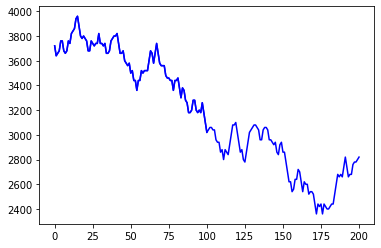

In [7]:
# Q-learning table사용
import scipy
import scipy.stats
import cupy as np
from cupy import asarray, concatenate, zeros, where, unique, asnumpy, bincount, argmax, \
argpartition, argsort, unravel_index, max as cmax, min as cmin, random as crandom
import numpy
from random import choice
import pylab
from collections import defaultdict
import pickle as pkl
from tqdm import tqdm_notebook

INITIALPRICE = 3800

def data_load():
    with open('./Data/dclus1.pkl', 'rb') as f:
        dclus = pkl.load(f)
        dclus = [asarray(i.astype('float').values) for i in dclus]
    
    with open('./Data/pp.pkl', 'rb') as f:
        pp = pkl.load(f)
        pp = [asarray(i.astype('float')) for i in pp]

    with open('./Data/dd.pkl', 'rb') as f:
        dd = pkl.load(f)
        dd = [asarray(i.astype('float')) for i in dd]
        
    return dclus, pp, dd
    
# 완전 랜덤 샘플링
def randomSampling(dc, num):
    # lon 최대 최소값, lat 최대 최소값
    max_lon, min_lon = max(dc[:, 0]), min(dc[:, 0])
    max_lat, min_lat = max(dc[:, 1]), min(dc[:, 1])
    
    # lon, lat값 랜덤 생성 후 매칭 반환
    sample_lon = crandom.uniform(low=min_lon, high=max_lon, size=(num,1))
    sample_lat = crandom.uniform(low=min_lat, high=max_lat, size=(num,1))
    return concatenate([sample_lon, sample_lat], axis=1)
def trip_Distance(idx, pp):
    """ OD """
    return pp[idx][:, 4].reshape(-1, 1)

def Calculate_distance(X1, X2):
    """ euclidean 거리계산 -> harvasion으로 변경 고려 """
    return ((X1 - X2)**2).sum(1)**0.5

def Calculate_Matrix(idx, dclus, pp, dd):
    """공차 샘플링"""
    # 85% 하차데이터 + 15% 랜덤테이터
    x1 = int(dd[idx].shape[0] * 0.85)
    x2 = dd[idx].shape[0] - x1

    # 15% 랜덤데이터 생성
    rS = randomSampling(dclus[idx], x2)
    x3 = crandom.choice(dd[idx].shape[0], x1, replace=False)
    x3 = concatenate([dd[idx][x3][:, :2], rS], axis = 0)

    """ PD """
    x = pp[idx][:, 0:2]     # 승객 위치
    y = x3[:, 0:2]         # 공차 위치
    matrix = zeros([x.shape[0],y.shape[0]]) # 매트릭스 초기화


    # d1 계산
    for idx, i in enumerate(x):
        matrix[idx] = Calculate_distance(i, y)

    # emin = 0이 아닌 최솟값
    emin = cmin(where(matrix == 0.0, 1, matrix))
    return 1 / (matrix + emin) * emin

def myHdbscan(train_data_robustScaled, cluster_size = 7):
    """auto HBSCAN"""
    import hdbscan
    test_data = train_data_robustScaled
    clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
    clusterer.fit(test_data)
    return clusterer, unique(clusterer.labels_).shape[0] # label갯수 리턴

def ScaledHdbscan(idx, pp, cluster_size = 7):
    from sklearn.preprocessing import RobustScaler
    
    #outlier 잡기 : Scaling
    robustScaler = RobustScaler()
#     train_data = pp[idx][:, :2]
    train_data = asnumpy(pp[idx][:, :2])
    print(robustScaler.fit(train_data))
    
    train_data_robustScaled = robustScaler.transform(train_data)
    
    # Hdbscan 적용
    return myHdbscan(train_data_robustScaled, cluster_size) # 4 ~ 8

def dbcluster(idx, pp, clusterer, k=3):
    """ DS """
    from knn import KNN

    X_train = pp[idx][:, 0:2]
    # 레이블이 -1부터가 아닌 0부터 시작시키기 위해 + 1
    t_train = clusterer.labels_ + 1
    X_test = pp[idx][:, 2:4]
    print("label : ", unique(t_train))
    K=3 # K = 3

    knn_train = KNN(K, X_train, t_train, unique(t_train))
    knn_train.show_dim()

    y2 = zeros(X_test.shape[0], dtype = int)

    for i in range(X_test.shape[0]):
        knn_train.get_nearest_k(X_test[i])
        y2[i] = knn_train.weighted_majority_vote()
        knn_train.reset()

    binc = bincount(y2)
    maxLabel = argmax(binc)
    maxLabelcount = cmax(binc)
    print("y2 : ", y2, "\ny2.bincount : ", binc)
    print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
    # 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 
    y2 = where(y2 == maxLabel, 1.2, (where(y2 == 0, 0.8, 1)))

    # 수 확인
    values, counts = unique(y2, return_counts=True)
    print("values: ",values,"counts: ", counts)

    y2 = y2.reshape(-1, 1)
    return y2

def mat2(PP, DP, next_state, PD, matrix):
    """ 승객, 운전자 시각에서의 각각 Matrix를 중앙값으로 구분 후 조합 """
    xPP = PP - next_state
    xDP = next_state - DP

    # 승객입장 Matrix : 거리, 가격을 따짐
    P_Matrix = PD * xPP
    # 운전자입장 Matrix : 거리, OD, DS, 가격을 따짐
    D_Matrix = matrix * xDP

    # 두 Matrix 0 ~ 1 Scaling
    P_Matrix -= P_Matrix.min() # 0 ~
    P_Matrix = P_Matrix / P_Matrix.max() # 0 ~ 1
    D_Matrix -= D_Matrix.min() # 0 ~
    D_Matrix = D_Matrix / D_Matrix.max() # 0 ~ 1

    # 중앙값 : outlier의 영향이 적기 때문,
    Pmid = numpy.median(asnumpy(P_Matrix))
    Dmid = numpy.median(asnumpy(D_Matrix))

    # 중앙값 미만의 확률들은 0으로 초기화
    P_Matrix = where(P_Matrix < Pmid, 0, P_Matrix)
    D_Matrix = where(D_Matrix < Dmid, 0, D_Matrix)
    
    newMatrix = P_Matrix * D_Matrix
    return newMatrix

def pick(newMatrix):
    """ Matrix에서 모든 수가 0인 행, 열 뺐을 경우 min(행, 열) """
    newMatrix = where(newMatrix == 0., 0, 1)

    Pa = newMatrix.shape[0]
    Dr = newMatrix.shape[1]

    if newMatrix.sum(1).min() == 0:
        Pa = where(newMatrix.sum(1) == 0, 0, 1).sum()

    if newMatrix.sum(0).min() == 0:
        Dr = where(newMatrix.sum(0) == 0, 0, 1).sum()
    return min(Pa, Dr)

def pick2(mat, threshold = 0.4):
    """ Matrix에서 중복없이 뽑는 알고리즘 """
    n = mat.size
    flat = mat.flatten()
    indices = argpartition(flat, -n)[-n:]
    indices = indices[argsort(-flat[indices])]
    x = unravel_index(indices, mat.shape)
#     print(x, mat.shape[0], mat.shape[1], n)
    xx = x[0]
    yy = x[1]
    
    x1 = zeros(mat.shape[0], dtype=int)
    y1 = zeros(mat.shape[0], dtype=int)
    x2 = zeros(mat.shape[1], dtype=int)
    y2 = zeros(mat.shape[1], dtype=int)

    idx=0
    for i in range(n):
        if(not x1[xx[i]] and not y1[yy[i]]):
    #         print(i, ": ",xx[i], yy[i])
    #   기준 점 잡기
            x1[xx[i]] = 1
            y1[yy[i]] = 1
            x2[idx]=xx[i]
            y2[idx]=yy[i]
            idx+=1
            
    return idx
#     print("x1 : ", x1,"\ny1: ", y1)
#     print("x1.shape[0] : ", x1.shape[0], "\ny1.shape[0] : ", y1.shape[0],"\nidx: ", idx)
#     print("x2: ", x2, "\ny2 : ", y2, "\nx2.shape[0]: ", x2.shape[0], "\ny2.shape[0]: ", y2.shape[0])
#     print("matrix: ", cmax(matrix))

# 환경
class Env:
    def __init__(self):
        self.action_space = ['u', 'l', 'c', 'r', 'd'] # 행동 순서대로 -80, -20, 0, +20, +80
        self.n_actions = len(self.action_space)  # 5 actions
        self.marketPrice = INITIALPRICE          # marketPrice 
        self.initPrice = INITIALPRICE            # InitialPrice
        self.PP = None    #Passenger의 선호 가격 리스트
        self.passengers = None #승객의 수 초기 500명
        self.DP = None    #Driver의 선호 가격 리스트
        self.drivers = None    #운전자 수 초기 500명
        self.matrix = None # matching matrix
        self.PD = None
        
    def step(self, action):
        if   action == 0:   # up : price-=80
            self.marketPrice-=80
            
        elif action == 1:   # left : price-=20
            self.marketPrice-=20
            
        elif action == 2:   # center : Nothing happen
            pass
        
        elif action == 3:   # right : price+=20
            self.marketPrice+=20

        elif action == 4:   # down : price+=80
            self.marketPrice+=80


        next_state = self.marketPrice
        reward = 0
        match = 0
        threshold = 0.4   # 기준점 어떻게?
        
        #보상 가격허용치를 넘으면 -100
        if next_state < (self.initPrice / 2) or next_state > (self.initPrice * 2):
            reward = -100
            
        else:
            """ 방법 2 Matrix 생성 후 뽑기"""
            newMatrix = mat2(self.PP, self.DP, next_state, self.PD, self.matrix)
            match = pick(newMatrix)
            reward = match * (next_state/1000)
            
#         else:
#             """기존"""
#             #보상 = next_state가격에서의 (match성사수) * (match 성사가격)
#             p_ok = self.acceptP(next_state, self.p_array)
#             d_ok = self.acceptD(next_state, self.d_array)
#             match = min([p_ok, d_ok])
#             reward = match * (next_state/1000)

        return next_state, reward
        
    def reset(self, PD, matrix):
        self.passengers = matrix.shape[0]
        self.drivers = matrix.shape[1]
        self.PP = crandom.normal(self.marketPrice, self.marketPrice / 20, self.passengers).reshape(-1, 1) #Passenger의 선호 가격 리스트
        self.DP = crandom.normal(self.marketPrice, self.marketPrice / 20, self.drivers) #Driver의 선호 가격 리스트
        # 매칭 매트릭스 초기화
        self.PD = PD
        self.matrix = matrix
        if self.initPrice is None:
            self.initPrice = INITIALPRICE
        else:
            self.initPrice = self.marketPrice
            
        return self.marketPrice
        
# 가격 Agent
class priceActionModel:
    def __init__(self, actions):
        # 행동 = [0, 1, 2, 3, 4] 순서대로 -80, -20, 0, +20, +80
        self.load_model = False
        self.actions = actions
        self.learning_rate = None
        self.discount_factor = None
        self.epsilon = 1.  # exploration
        self.epsilon_decay = None
        self.epsilon_min = None
        self.q_table = None # 5열
        
    # <s, a, r, s'> 샘플로부터 큐함수 업데이트
    def learn(self, state, action, reward, next_state):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        q_1 = self.q_table[state][action]
        # 벨만 최적 방정식을 사용한 큐함수의 업데이트
        q_2 = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (q_2 - q_1)
    
    # 큐함수에 의거하여 입실론 탐욕 정책에 따라서 행동을 반환
    def get_action(self, state):
        if crandom.rand() < self.epsilon:
            
            action = choice(self.actions)
        else:
            # 큐함수에 따른 행동 반환
            print(state, self.q_table[state])
            state_action = self.q_table[state]
            action = self.arg_max(state_action)
        return action
        
    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return choice(max_index_list)
    
    def reset(self):
        self.load_model = False
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0, 0.0, 0.0]) # 5열
        
if __name__ == "__main__":
    # Data_load
    dclus, pp, dd = data_load()
    
    env = Env()
    agent = priceActionModel(actions=list(range(env.n_actions)))            # [0, 1, 2, 3, 4]
    
    global_step = 0
    scores, episodes = [], []
    
    for episode in tqdm_notebook(range(24)):
        # 매칭 매트릭스 계산
        PD = Calculate_Matrix(episode, dclus, pp, dd)
        OD = trip_Distance(episode, pp)
        clusterer, labelNum = ScaledHdbscan(episode, pp, cluster_size = 7)
        DS = dbcluster(episode, pp, clusterer, k = 3)
        matrix = PD * OD * DS
        
        state = env.reset(PD, matrix)
        agent.reset()
        for i in tqdm_notebook(range(50000)):
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(str(state))
            
            # 행동을 취한 후 다음 상태, 보상 에피소드의 종료여부를 받아옴
            next_state, reward = env.step(action)

            # <s,a,r,s'>로 큐함수를 업데이트
            agent.learn(str(state), action, reward, str(next_state))
            state = next_state
            # 모든 큐함수를 화면에 표시
            #env.print_value_all(agent.q_table)
            
            scores.append(state)
            episodes.append(episode*50000 + i)
            if((i % 100) == 0):
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./DP_graph{}.png".format(episode))
                print("episode:", episode, "  score:", state, " global_step:",
                      global_step, "  epsilon:", agent.epsilon)
            